In [11]:
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import random_split, DataLoader
from torchvision.models import vgg19
import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from brisque import BRISQUE
from dataset import EXRDataset
import torch.nn.functional as F

In [12]:
# enable using OpenEXR with OpenCV
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = "1"

FILE_PATH = os.path.normpath("./data/reference/001.exr")

def read_exr(im_path: str) -> np.ndarray:
    return cv2.imread(
    filename=im_path,
    flags=cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH
    )
def tone_map_reinhard(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapReinhard(
    gamma=2.2,
    intensity=0.0,
    light_adapt=0.0,
    color_adapt=0.0
    )
    result = tonemap_operator.process(src=image)
    return result
def tone_map_mantiuk(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapMantiuk(
    gamma=2.2,
    scale=0.85,
    saturation=1.2
    )
    result = tonemap_operator.process(src=image)
    return result

def evaluate_image(image: np.ndarray) -> float:
    metric = BRISQUE(url=False)
    return metric.score(img=image)

def fix_colors(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def clip(img):
    return np.clip(img / np.max(img), 0, 1)

In [3]:
# image = read_exr(im_path=FILE_PATH)
# tone_mapped_reinhard = tone_map_reinhard(image)
# tone_mapped_mantiuk = tone_map_mantiuk(image)

# fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 

# axes[0].imshow(fix_colors(clip(image)))
# axes[0].axis('off')
# axes[0].set_title("original")

# axes[1].imshow(fix_colors(tone_mapped_reinhard))
# axes[1].axis('off')
# axes[1].set_title("tone_mapped_reinhard")

# axes[2].imshow(fix_colors(tone_mapped_mantiuk))
# axes[2].axis('off')
# axes[2].set_title("tone_mapped_mantiuk")

# print('tone_mapped_reinhard', evaluate_image(image=tone_mapped_reinhard))
# print('tone_mapped_mantiuk', evaluate_image(image=tone_mapped_mantiuk))

# 3.1 Multiple Exposure Selection

In [13]:
def aces_estimation(t=0.85, A=2.51, B=0.03, C=2.43, D=0.59, E=0.14):
    # (tC - A)x^2 + (tD - B)x + tE = 0
    a = t * C - A
    b = t * D - B
    c = t * E

    delta = b ** 2 - 4 * a * c
    return (-b - np.sqrt(delta)) / (2 * a)

def exposures(img: torch.Tensor):
    x_p = aces_estimation()

    c_start = torch.log(x_p / torch.max(img))

    percentile_50 = torch.quantile(img, 0.5)
    c_end = torch.log2(x_p / percentile_50)

    output_list = []
    exp_value = [c_start, (c_end + c_start) / 2.0, c_end]
    for value in exp_value:
        sc = torch.pow(torch.sqrt(torch.tensor(2.0)), value)
        img_exp = img * sc
        img_out = torch.clip(img_exp, 0, 1)
        output_list.append(img_out)

    return output_list

In [5]:
# def normalize(img):
#     return img * (0.5 / np.mean(img))

# img_low, img_mid, img_high = exposures(torch.from_numpy(normalize(image)))

# fig, axes = plt.subplots(1, 4, figsize=(10, 10)) 

# axes[0].imshow(fix_colors(normalize(image)))
# axes[0].axis('off')
# axes[0].set_title("I-src")


# axes[1].imshow(fix_colors(img_low.detach().cpu().numpy()))
# axes[1].axis('off')
# axes[1].set_title("I-e-low")

# axes[2].imshow(fix_colors(img_mid.detach().cpu().numpy()))
# axes[2].axis('off')
# axes[2].set_title("I-e-mid")

# axes[3].imshow(fix_colors(img_high.detach().cpu().numpy()))
# axes[3].axis('off')
# axes[3].set_title("I-e-high")

# 3.2 Tone Mapping Network

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Conv2d(192, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, exp1, exp2, exp3):
        x = self.decoder(x)
        residual = x + exp1 + exp2 + exp3
        return self.sigmoid(residual)
    

class SelfTMO(nn.Module):
    def __init__(self):
        super(SelfTMO, self).__init__()

        # 1 instance of encoder to share the weights
        self.encoder = Encoder()
        
        self.fusion = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(192, 192, kernel_size=1, stride=1)
        )

        self.decoder = Decoder()

    def forward(self, exp1, exp2, exp3):
        exp1_enc = self.encoder(exp1)
        exp2_enc = self.encoder(exp2)
        exp3_enc = self.encoder(exp3)

        concat = torch.concat([exp1_enc, exp2_enc, exp3_enc], axis = 1)
        
        concat = self.fusion(concat)
        concat = self.decoder(concat, exp1, exp2, exp3)

        return concat

# 3.3 Adaptive μ-law compression

In [15]:
def mi_law(input, lambda1=8.759, lambda2=0.1494, gamma1=2.148, gamma2=-2.067):
    return lambda1 * (input ** gamma1) + lambda2 * (input ** gamma2)

def mi_img(img: np.ndarray):
    law_value = mi_law(img)
    return torch.log(1+law_value*img)/torch.log(1+law_value)

# 3.4 Feature Contrast Masking Loss

# Training

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda


In [17]:
model_vgg19 = vgg19(pretrained=True).features[:18].to(device)
model_vgg19.eval()

def feature_contrast(feature_map, patch_size=13, epsilon=1e-4):
    kernel = torch.ones(feature_map.shape[1], 1, patch_size, patch_size, device=feature_map.device) / (patch_size ** 2)
    
    gauss = F.conv2d(feature_map, kernel, padding=patch_size//2, groups=feature_map.shape[1])
    
    return (feature_map - gauss) / (torch.abs(gauss) + epsilon)


def feature_contrast_self_masking(feature_map, alpha):  # mi: alpha=0.5, TM: alpha=1
    C = feature_contrast(feature_map)
    return torch.sign(C)*torch.abs(C)**alpha


def feature_contrast_neighborhood_masking(feature_map, patch_size=13, epsilon=1e-4):
    kernel = torch.ones((feature_map.shape[1], 1, patch_size, patch_size), dtype=torch.float32, device=feature_map.device) / (patch_size ** 2)
    
    mi_b = F.conv2d(feature_map, kernel, padding=patch_size//2, groups=feature_map.shape[1])
    
    feature_map_squared = feature_map ** 2
    mi_b_squared = F.conv2d(feature_map_squared, kernel, padding=patch_size//2, groups=feature_map.shape[1])
    
    sigma_b = torch.sqrt(mi_b_squared - mi_b ** 2 + epsilon)
    
    contrast_map = sigma_b / (torch.abs(mi_b) + epsilon)
    
    return contrast_map.squeeze(0)

    
def f(Ms, Mn):
    return Ms / (1+Mn)

def loss(I_mi, I_tm):
    mi_vgg = model_vgg19(I_mi)
    tm_vgg = model_vgg19(I_tm)
    return torch.abs(
        f(feature_contrast_self_masking(mi_vgg, 0.5), feature_contrast_neighborhood_masking(mi_vgg)) - 
        f(feature_contrast_self_masking(tm_vgg, 1), feature_contrast_neighborhood_masking(tm_vgg))
    )

/home/dominik/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dominik/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
model = SelfTMO()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [19]:
dataset = EXRDataset("./data/processed")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [20]:
num_epochs = 400
losses = {"train":[],"val":[]}

for epoch in range(num_epochs):
    model.train()
    for img in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        img = img.to(device)

        img_low, img_mid, img_high = exposures(img)

        I_tm = model(img_low, img_mid, img_high)
        I_mi = mi_img(img)

        a = loss(I_mi, I_tm).mean()

        a.backward()
        optimizer.step()
    
    model.eval()
    print(f"epoch #{epoch+1}, loss: {a}")
    losses["train"].append(a.item())
    with torch.no_grad():
        total_loss = 0.0
        for img in val_dataset:
            img = img.unsqueeze(0).to(device)
            img_low, img_mid, img_high = exposures(img)
            I_tm = model(img_low, img_mid, img_high)

            I_mi = mi_img(img)

            a = loss(I_mi, I_tm)
            total_loss += a.mean().item()
        print("Validation loss:",total_loss / len(val_dataset))
    losses["val"].append(total_loss)

    if (epoch + 1) % 10 == 0:
        scheduler.step()

100%|██████████| 144/144 [00:31<00:00,  4.55it/s]


epoch #1, loss: 0.19819149374961853
Validation loss: 0.1852809484746005


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #2, loss: 0.13342516124248505
Validation loss: 0.17302975642520027


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #3, loss: 0.203570157289505
Validation loss: 0.16716895212192792


100%|██████████| 144/144 [00:31<00:00,  4.56it/s]


epoch #4, loss: 0.11401714384555817
Validation loss: 0.15458812242424166


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #5, loss: 0.15519851446151733
Validation loss: 0.15514308516238187


100%|██████████| 144/144 [00:31<00:00,  4.57it/s]


epoch #6, loss: 0.12710396945476532
Validation loss: 0.14971129072679057


100%|██████████| 144/144 [00:30<00:00,  4.69it/s]


epoch #7, loss: 0.18299996852874756
Validation loss: 0.14759715223634565


100%|██████████| 144/144 [00:31<00:00,  4.62it/s]


epoch #8, loss: 0.1328955888748169
Validation loss: 0.14765006827341542


100%|██████████| 144/144 [00:31<00:00,  4.62it/s]


epoch #9, loss: 0.15078940987586975
Validation loss: 0.14638296313382484


100%|██████████| 144/144 [00:31<00:00,  4.62it/s]


epoch #10, loss: 0.10130713135004044
Validation loss: 0.1446656584739685


100%|██████████| 144/144 [00:31<00:00,  4.62it/s]


epoch #11, loss: 0.19721144437789917
Validation loss: 0.14352233103803685


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #12, loss: 0.13089986145496368
Validation loss: 0.14689157802510905


100%|██████████| 144/144 [00:31<00:00,  4.61it/s]


epoch #13, loss: 0.13334079086780548
Validation loss: 0.14444745875693657


100%|██████████| 144/144 [00:31<00:00,  4.61it/s]


epoch #14, loss: 0.14384523034095764
Validation loss: 0.1476897573148882


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #15, loss: 0.17208747565746307
Validation loss: 0.14331165741424304


100%|██████████| 144/144 [00:31<00:00,  4.57it/s]


epoch #16, loss: 0.1252388060092926
Validation loss: 0.15177456732537295


100%|██████████| 144/144 [00:32<00:00,  4.45it/s]


epoch #17, loss: 0.15191516280174255
Validation loss: 0.1432196066991703


100%|██████████| 144/144 [00:32<00:00,  4.45it/s]


epoch #18, loss: 0.13088616728782654
Validation loss: 0.1430689932124035


100%|██████████| 144/144 [00:32<00:00,  4.46it/s]


epoch #19, loss: 0.07424558699131012
Validation loss: 0.14230445007214676


100%|██████████| 144/144 [00:32<00:00,  4.46it/s]


epoch #20, loss: 0.14997702836990356
Validation loss: 0.14090607214618373


100%|██████████| 144/144 [00:32<00:00,  4.43it/s]


epoch #21, loss: 0.14487305283546448
Validation loss: 0.14303333674733704


100%|██████████| 144/144 [00:32<00:00,  4.44it/s]


epoch #22, loss: 0.14196285605430603
Validation loss: 0.14550508397656517


100%|██████████| 144/144 [00:32<00:00,  4.48it/s]


epoch #23, loss: 0.14800584316253662
Validation loss: 0.13961518475332776


100%|██████████| 144/144 [00:31<00:00,  4.62it/s]


epoch #24, loss: 0.15546546876430511
Validation loss: 0.1439252761570183


100%|██████████| 144/144 [00:32<00:00,  4.44it/s]


epoch #25, loss: 0.17026977241039276
Validation loss: 0.13905528429392222


100%|██████████| 144/144 [00:32<00:00,  4.49it/s]


epoch #26, loss: 0.1497214287519455
Validation loss: 0.13927704458301132


100%|██████████| 144/144 [00:32<00:00,  4.46it/s]


epoch #27, loss: 0.09563519805669785
Validation loss: 0.14099342879411336


100%|██████████| 144/144 [00:32<00:00,  4.46it/s]


epoch #28, loss: 0.1738140732049942
Validation loss: 0.14165471856658524


100%|██████████| 144/144 [00:32<00:00,  4.49it/s]


epoch #29, loss: 0.0916300117969513
Validation loss: 0.139067124474693


100%|██████████| 144/144 [00:32<00:00,  4.50it/s]


epoch #30, loss: 0.16334974765777588
Validation loss: 0.1427439682789751


100%|██████████| 144/144 [00:32<00:00,  4.45it/s]


epoch #31, loss: 0.13258036971092224
Validation loss: 0.13822926601042618


100%|██████████| 144/144 [00:32<00:00,  4.43it/s]


epoch #32, loss: 0.14521101117134094
Validation loss: 0.1400893374874785


100%|██████████| 144/144 [00:32<00:00,  4.41it/s]


epoch #33, loss: 0.1128699779510498
Validation loss: 0.13889172834319038


100%|██████████| 144/144 [00:32<00:00,  4.46it/s]


epoch #34, loss: 0.1401609480381012
Validation loss: 0.13764069551551664


100%|██████████| 144/144 [00:31<00:00,  4.50it/s]


epoch #35, loss: 0.11445170640945435
Validation loss: 0.14367837942129857


100%|██████████| 144/144 [00:31<00:00,  4.51it/s]


epoch #36, loss: 0.10477296262979507
Validation loss: 0.13815328559359988


100%|██████████| 144/144 [00:32<00:00,  4.48it/s]


epoch #37, loss: 0.09698200225830078
Validation loss: 0.1396750900390986


100%|██████████| 144/144 [00:31<00:00,  4.61it/s]


epoch #38, loss: 0.10778302699327469
Validation loss: 0.1387918299517116


100%|██████████| 144/144 [00:30<00:00,  4.69it/s]


epoch #39, loss: 0.09621123969554901
Validation loss: 0.1386208302668623


100%|██████████| 144/144 [00:31<00:00,  4.62it/s]


epoch #40, loss: 0.15690632164478302
Validation loss: 0.13866675181968793


100%|██████████| 144/144 [00:31<00:00,  4.62it/s]


epoch #41, loss: 0.12038268148899078
Validation loss: 0.13833351594370766


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #42, loss: 0.13338975608348846
Validation loss: 0.1391929893477543


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #43, loss: 0.12927627563476562
Validation loss: 0.13758663571364171


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #44, loss: 0.1223054826259613
Validation loss: 0.13856112070985743


100%|██████████| 144/144 [00:31<00:00,  4.57it/s]


epoch #45, loss: 0.08623071014881134
Validation loss: 0.13873209079375137


100%|██████████| 144/144 [00:31<00:00,  4.61it/s]


epoch #46, loss: 0.1131025180220604
Validation loss: 0.13839651906007044


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #47, loss: 0.10852188616991043
Validation loss: 0.13709866879759608


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #48, loss: 0.2164030224084854
Validation loss: 0.13847957007788322


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #49, loss: 0.15807320177555084
Validation loss: 0.1384723331477191


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #50, loss: 0.12188588082790375
Validation loss: 0.13992885278688894


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #51, loss: 0.13021746277809143
Validation loss: 0.13796767270242846


100%|██████████| 144/144 [00:31<00:00,  4.56it/s]


epoch #52, loss: 0.16166344285011292
Validation loss: 0.1380049676911251


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #53, loss: 0.14089591801166534
Validation loss: 0.13647175982997223


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #54, loss: 0.10882927477359772
Validation loss: 0.13748426916631493


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #55, loss: 0.13553884625434875
Validation loss: 0.13734876807477023


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #56, loss: 0.14869779348373413
Validation loss: 0.13744438802068298


100%|██████████| 144/144 [00:31<00:00,  4.61it/s]


epoch #57, loss: 0.09361597150564194
Validation loss: 0.13687955688785863


100%|██████████| 144/144 [00:31<00:00,  4.57it/s]


epoch #58, loss: 0.12200692296028137
Validation loss: 0.14007242487089053


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #59, loss: 0.13520705699920654
Validation loss: 0.13719155800503655


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #60, loss: 0.1628933697938919
Validation loss: 0.13845347311045672


100%|██████████| 144/144 [00:31<00:00,  4.61it/s]


epoch #61, loss: 0.13341504335403442
Validation loss: 0.13674849291910995


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #62, loss: 0.17210960388183594
Validation loss: 0.13591885566711426


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #63, loss: 0.12387928366661072
Validation loss: 0.13746591556716609


100%|██████████| 144/144 [00:30<00:00,  4.76it/s]


epoch #64, loss: 0.1331987977027893
Validation loss: 0.13670462188688484


100%|██████████| 144/144 [00:30<00:00,  4.75it/s]


epoch #65, loss: 0.15799041092395782
Validation loss: 0.13874595249826843


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #66, loss: 0.12653318047523499
Validation loss: 0.13673170031727971


100%|██████████| 144/144 [00:31<00:00,  4.57it/s]


epoch #67, loss: 0.10240022093057632
Validation loss: 0.13697401716096982


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #68, loss: 0.15505021810531616
Validation loss: 0.1369494505830713


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #69, loss: 0.14682897925376892
Validation loss: 0.13639009441878344


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #70, loss: 0.16669398546218872
Validation loss: 0.13736977448334564


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #71, loss: 0.1265283226966858
Validation loss: 0.13555721797653147


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #72, loss: 0.10951618105173111
Validation loss: 0.13641507843056241


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #73, loss: 0.12344752997159958
Validation loss: 0.13656650302377907


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #74, loss: 0.14107109606266022
Validation loss: 0.13646596931927912


100%|██████████| 144/144 [00:31<00:00,  4.56it/s]


epoch #75, loss: 0.08695296943187714
Validation loss: 0.13674894418265368


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #76, loss: 0.17694136500358582
Validation loss: 0.13680355935483365


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #77, loss: 0.13116592168807983
Validation loss: 0.13691370531513886


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #78, loss: 0.10064750909805298
Validation loss: 0.13612120256230636


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #79, loss: 0.09388737380504608
Validation loss: 0.1364344583975302


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #80, loss: 0.15102910995483398
Validation loss: 0.13642193175650932


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #81, loss: 0.07034891843795776
Validation loss: 0.13661427151512456


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #82, loss: 0.1129014864563942
Validation loss: 0.1350937107124844


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #83, loss: 0.21430891752243042
Validation loss: 0.13585198972676252


100%|██████████| 144/144 [00:31<00:00,  4.54it/s]


epoch #84, loss: 0.14249561727046967
Validation loss: 0.1370533297996263


100%|██████████| 144/144 [00:31<00:00,  4.50it/s]


epoch #85, loss: 0.14880937337875366
Validation loss: 0.1363596722886369


100%|██████████| 144/144 [00:30<00:00,  4.65it/s]


epoch #86, loss: 0.13816875219345093
Validation loss: 0.136944386806037


100%|██████████| 144/144 [00:31<00:00,  4.63it/s]


epoch #87, loss: 0.08599478006362915
Validation loss: 0.13674392208859726


100%|██████████| 144/144 [00:31<00:00,  4.61it/s]


epoch #88, loss: 0.1127396672964096
Validation loss: 0.13748278650077614


100%|██████████| 144/144 [00:31<00:00,  4.62it/s]


epoch #89, loss: 0.13833200931549072
Validation loss: 0.13803781005176338


100%|██████████| 144/144 [00:30<00:00,  4.78it/s]


epoch #90, loss: 0.13547030091285706
Validation loss: 0.13633931629561089


100%|██████████| 144/144 [00:30<00:00,  4.78it/s]


epoch #91, loss: 0.15166249871253967
Validation loss: 0.13805944935695544


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #92, loss: 0.11146512627601624
Validation loss: 0.13627935925850998


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #93, loss: 0.12142284214496613
Validation loss: 0.1361959461827536


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #94, loss: 0.13783738017082214
Validation loss: 0.13666970806347356


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #95, loss: 0.12815970182418823
Validation loss: 0.13588592269130656


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #96, loss: 0.10408683121204376
Validation loss: 0.13610674481134158


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #97, loss: 0.13803769648075104
Validation loss: 0.1365046901880084


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #98, loss: 0.14780688285827637
Validation loss: 0.1365870867629309


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #99, loss: 0.14783194661140442
Validation loss: 0.1366843007303573


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #100, loss: 0.12860578298568726
Validation loss: 0.13611424110225728


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #101, loss: 0.10538482666015625
Validation loss: 0.1358605500411343


100%|██████████| 144/144 [00:31<00:00,  4.60it/s]


epoch #102, loss: 0.11566182971000671
Validation loss: 0.1356574913134446


100%|██████████| 144/144 [00:31<00:00,  4.56it/s]


epoch #103, loss: 0.11809743195772171
Validation loss: 0.13596474943128792


100%|██████████| 144/144 [00:32<00:00,  4.49it/s]


epoch #104, loss: 0.12007839232683182
Validation loss: 0.1364368162042386


100%|██████████| 144/144 [00:32<00:00,  4.48it/s]


epoch #105, loss: 0.08094620704650879
Validation loss: 0.13682068199724765


100%|██████████| 144/144 [00:32<00:00,  4.46it/s]


epoch #106, loss: 0.14785423874855042
Validation loss: 0.13587518660603343


100%|██████████| 144/144 [00:32<00:00,  4.48it/s]


epoch #107, loss: 0.10911454260349274
Validation loss: 0.13567162768260851


100%|██████████| 144/144 [00:32<00:00,  4.47it/s]


epoch #108, loss: 0.16769565641880035
Validation loss: 0.13588018997295484


100%|██████████| 144/144 [00:31<00:00,  4.51it/s]


epoch #109, loss: 0.20523664355278015
Validation loss: 0.13664657360798604


100%|██████████| 144/144 [00:32<00:00,  4.50it/s]


epoch #110, loss: 0.16148698329925537
Validation loss: 0.13526690288169965


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #111, loss: 0.12281676381826401
Validation loss: 0.1361715008278151


100%|██████████| 144/144 [00:30<00:00,  4.75it/s]


epoch #112, loss: 0.16128262877464294
Validation loss: 0.13631729278210047


100%|██████████| 144/144 [00:30<00:00,  4.79it/s]


epoch #113, loss: 0.11320102959871292
Validation loss: 0.1379760074857119


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #114, loss: 0.1024702712893486
Validation loss: 0.13564332272555377


100%|██████████| 144/144 [00:32<00:00,  4.48it/s]


epoch #115, loss: 0.0989963710308075
Validation loss: 0.13647070063932523


100%|██████████| 144/144 [00:31<00:00,  4.61it/s]


epoch #116, loss: 0.1110948920249939
Validation loss: 0.1360878217461947


100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


epoch #117, loss: 0.15068276226520538
Validation loss: 0.13581263535731547


100%|██████████| 144/144 [00:31<00:00,  4.58it/s]


epoch #118, loss: 0.12337666749954224
Validation loss: 0.1350232697016484


 97%|█████████▋| 139/144 [00:30<00:01,  4.53it/s]


KeyboardInterrupt: 

In [26]:
import random

def lum(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    l = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return l

def color_correction(img_in, img_out, s=0.6):
    l_in = lum(img_in)
    l_out = lum(img_out)

    l_in = l_in[..., np.newaxis]
    l_out = l_out[..., np.newaxis]

    return l_out * (img_in / l_in) ** s

In [ ]:
# torch.save(model, 'test100.pth')
torch.load('100epochs.pth', weights_only=False)

     Image  Tone Mapped Reinhard  Tone Mapped Mantiuk      Model
0  Image 0             34.355169            65.600459  48.319397
1  Image 1             24.933873            84.177706  59.747010
2  Image 2             25.619132            70.643752  45.218991
3  Image 3              0.015369            32.776839  12.982823


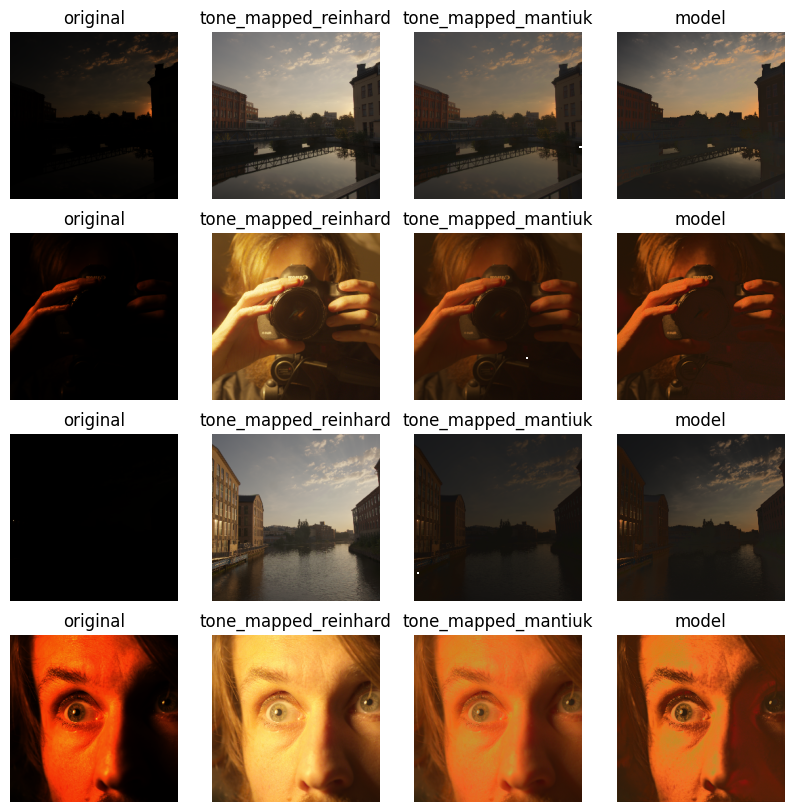

In [32]:
model.eval()

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
results = []

for i in range(4):
    image = random.choice(val_dataset)
    image_org = clip(image.numpy().transpose(1, 2, 0))
    image = image.unsqueeze(0).to(device)

    img_low, img_mid, img_high = exposures(image)
    result = model(img_low, img_mid, img_high).squeeze(0)
    result = result.cpu().detach().numpy().transpose(1, 2, 0)

    tone_mapped_reinhard = tone_map_reinhard(image_org)
    tone_mapped_mantiuk = tone_map_mantiuk(image_org)
    result_corrected = clip(color_correction(image_org, result))

    axes[i, 0].imshow(fix_colors(image_org))
    axes[i, 0].axis('off')
    axes[i, 0].set_title("original")

    axes[i, 1].imshow(fix_colors(tone_mapped_reinhard))
    axes[i, 1].axis('off')
    axes[i, 1].set_title("tone_mapped_reinhard")

    axes[i, 2].imshow(fix_colors(tone_mapped_mantiuk))
    axes[i, 2].axis('off')
    axes[i, 2].set_title("tone_mapped_mantiuk")

    axes[i, 3].imshow(fix_colors(result_corrected))
    axes[i, 3].axis('off')
    axes[i, 3].set_title("model")

    eval_reinhard = evaluate_image(image=tone_mapped_reinhard)
    eval_mantiuk = evaluate_image(image=tone_mapped_mantiuk)
    eval_model = evaluate_image(image=result_corrected)

    results.append({
        'Image': f'Image {i}',
        'Tone Mapped Reinhard': eval_reinhard,
        'Tone Mapped Mantiuk': eval_mantiuk,
        'Model': eval_model
    })

print(pd.DataFrame(results))